<a href="https://colab.research.google.com/github/Downhill1999/Project-ML-netology/blob/main/%22%D0%97%D0%B0%D0%B4%D0%B0%D1%87%D0%B0_%22%D0%9A%D0%BE%D0%BD%D0%B2%D0%B5%D1%80%D1%81%D0%B8%D1%8F_%D0%BF%D0%BE_%D0%B4%D0%BB%D0%B8%D0%BD%D0%B5_%D0%B7%D0%B0%D0%BF%D1%80%D0%BE%D1%81%D0%BE%D0%B2_%D0%B1%D0%B5%D0%B7_%D0%BE%D1%82%D1%87%D0%B8%D1%81%D1%82%D0%BA%D0%B8_%D0%B2%D1%8B%D0%B1%D1%80%D0%BE%D1%81%D0%BE%D0%B2%22_ipynb%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Цель:

Определить группу запросов по длинне символов - Какая длинна запросов приносит наибольшую прибыль
Для выявления длинны запросов по которым мы проседаем (удлинять запрос/укарачивать запрос)

Сначала пробую линейную регрессию, потом случайный лес.

Сравню метрики качества обеих моделей, выберу лучший вариант.

После сделаю интерпритацию результатов, согласно ТЗ

**1. Выгрузка данных и первичный анализ**

In [254]:
#Импорт необходимых библиотек
import pandas as pd
import numpy as np
import seaborn as sns
import scipy.stats
import sklearn.datasets
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import random

In [255]:
data = pd.read_csv(
    'https://raw.githubusercontent.com/Downhill1999/VI.tech-ML/main/length_Search_ML.csv?token=GHSAT0AAAAAACPNGM7DREJUWOEQ7CUBWACQZRM2CTQ',
    on_bad_lines='skip',
    sep=','  # Явное указание разделителя
)

In [256]:
data.head()

,Запрос,Кол-во сессий с поиском,Кол-во пользователей поиска,Сесиий с добавлением,Кол-во заказов с поиска,GMV поиска,CR в добавление,Доля переходов корзина - заказ,CR с поиска в заказ,Кол-во символов в строке
0,мойки высокого давления,8561.0,7491.0,1528.0,299.0,5169480.0,0.113188,0.18324607329842932,0.032706,23
1,гайковерты,8229.0,7314.0,1586.0,237.0,4503354.0,0.111314,0.1424968474148802,0.027464,10
2,компрессор,7460.0,6897.0,1207.0,213.0,5809503.0,0.116756,0.16652858326429162,0.026944,10
3,компрессоры,7406.0,6747.0,1320.0,213.0,6838667.0,0.115717,0.15075757575757576,0.026870,11
4,шуруповерт,6989.0,6058.0,1638.0,415.0,5347270.0,0.165260,0.23321123321123322,0.054657,10


In [257]:
data.info() #Информация о датасете

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17964 entries, 0 to 17963
Data columns (total 10 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Запрос                          17964 non-null  object 
 1   Кол-во сессий с поиском         17585 non-null  float64
 2   Кол-во пользователей поиска     17585 non-null  float64
 3   Сесиий с добавлением            17585 non-null  float64
 4   Кол-во заказов с поиска         17585 non-null  float64
 5   GMV поиска                      11294 non-null  float64
 6   CR в добавление                 17585 non-null  float64
 7   Доля переходов корзина - заказ  17585 non-null  object 
 8   CR с поиска в заказ             17585 non-null  float64
 9   Кол-во символов в строке        17964 non-null  int64  
dtypes: float64(7), int64(1), object(2)
memory usage: 1.4+ MB


In [258]:
#Уберём строки с пропущенными данными

columns_to_check = [
    'Запрос', 'Кол-во сессий с поиском', 'Кол-во пользователей поиска',
    'Сесиий с добавлением', 'Кол-во заказов с поиска', 'GMV поиска',
    'CR в добавление', 'Доля переходов корзина - заказ', 'CR с поиска в заказ',
    'Кол-во символов в строке'
]

data = data.dropna(subset=columns_to_check)

In [259]:
data.info() #Проверка данных после удаления пропусков

<class 'pandas.core.frame.DataFrame'>
Index: 11294 entries, 0 to 17962
Data columns (total 10 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Запрос                          11294 non-null  object 
 1   Кол-во сессий с поиском         11294 non-null  float64
 2   Кол-во пользователей поиска     11294 non-null  float64
 3   Сесиий с добавлением            11294 non-null  float64
 4   Кол-во заказов с поиска         11294 non-null  float64
 5   GMV поиска                      11294 non-null  float64
 6   CR в добавление                 11294 non-null  float64
 7   Доля переходов корзина - заказ  11294 non-null  object 
 8   CR с поиска в заказ             11294 non-null  float64
 9   Кол-во символов в строке        11294 non-null  int64  
dtypes: float64(7), int64(1), object(2)
memory usage: 970.6+ KB


Дальше нужно убрать "-" в строках, т.к при первичном анализе было видно что присутствуют данные без статистики

In [260]:
columns_to_check = [
    'Кол-во сессий с поиском', 'Кол-во пользователей поиска',
    'Сесиий с добавлением', 'Кол-во заказов с поиска', 'GMV поиска',
    'CR в добавление', 'Доля переходов корзина - заказ', 'CR с поиска в заказ',
    'Кол-во символов в строке'
    ]

for column in columns_to_check:
    data[column] = data[column].replace("-", np.nan)

data.dropna(subset=columns_to_check, inplace=True)

In [261]:
data.info() #Проверка данных после удаления "-"

<class 'pandas.core.frame.DataFrame'>
Index: 11199 entries, 0 to 17962
Data columns (total 10 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Запрос                          11199 non-null  object 
 1   Кол-во сессий с поиском         11199 non-null  float64
 2   Кол-во пользователей поиска     11199 non-null  float64
 3   Сесиий с добавлением            11199 non-null  float64
 4   Кол-во заказов с поиска         11199 non-null  float64
 5   GMV поиска                      11199 non-null  float64
 6   CR в добавление                 11199 non-null  float64
 7   Доля переходов корзина - заказ  11199 non-null  object 
 8   CR с поиска в заказ             11199 non-null  float64
 9   Кол-во символов в строке        11199 non-null  int64  
dtypes: float64(7), int64(1), object(2)
memory usage: 962.4+ KB


In [262]:
#Обозначим X и Y

x = data[['Кол-во сессий с поиском', 'Кол-во пользователей поиска',
    'Сесиий с добавлением', 'Кол-во заказов с поиска', 'GMV поиска',
    'CR в добавление', 'Доля переходов корзина - заказ', 'CR с поиска в заказ', 'Кол-во символов в строке']]
x = x.drop('GMV поиска', axis=1)

y = data[['GMV поиска']]

array([[<Axes: title={'center': 'Кол-во символов в строке'}>]],
      dtype=object)

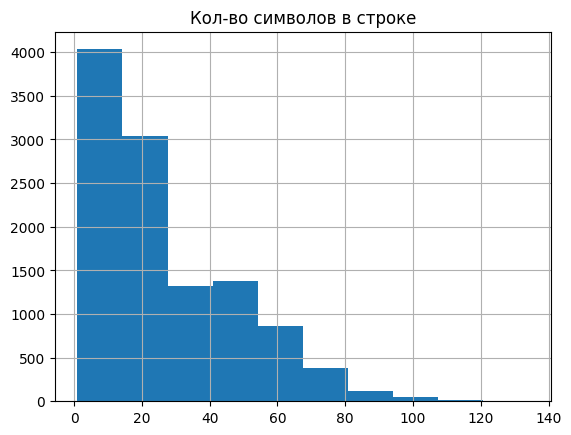

In [263]:
x.hist(column=['Кол-во символов в строке']) #Визуализируем данные из колонки "Кол-во символов в строке", чтобы можно было определить какие группы у нас есть

<Axes: >

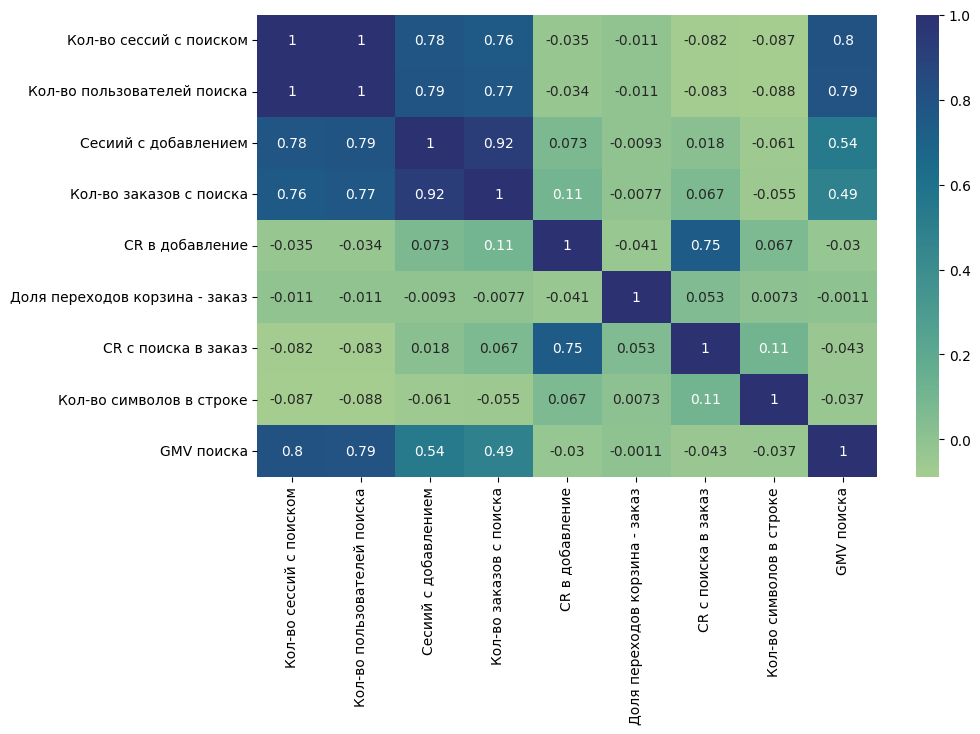

In [264]:
#Теперь выведем корреляционную матрицу, чтобы оценить какие переменные коррелируют лучше всего друг с другом
plt.figure(figsize=(10,6)) #Высчитываем корреляцию между столбцами в датафрейме, делим ячейки по цветам
sns.heatmap(pd.concat([x,y], axis=1).corr(), cmap='crest',annot=True)

#Видим что порог корреляции от 0.8 не преодолен, поэтому отбирать признаки пока что не будем, посмотрим на итоговое качество модели.

In [265]:
selected_features_x = ['Кол-во сессий с поиском', 'Кол-во заказов с поиска', 'Кол-во символов в строке']
X = x[selected_features_x]
selected_features_y = ['GMV поиска']
Y = y[selected_features_y]

<Axes: >

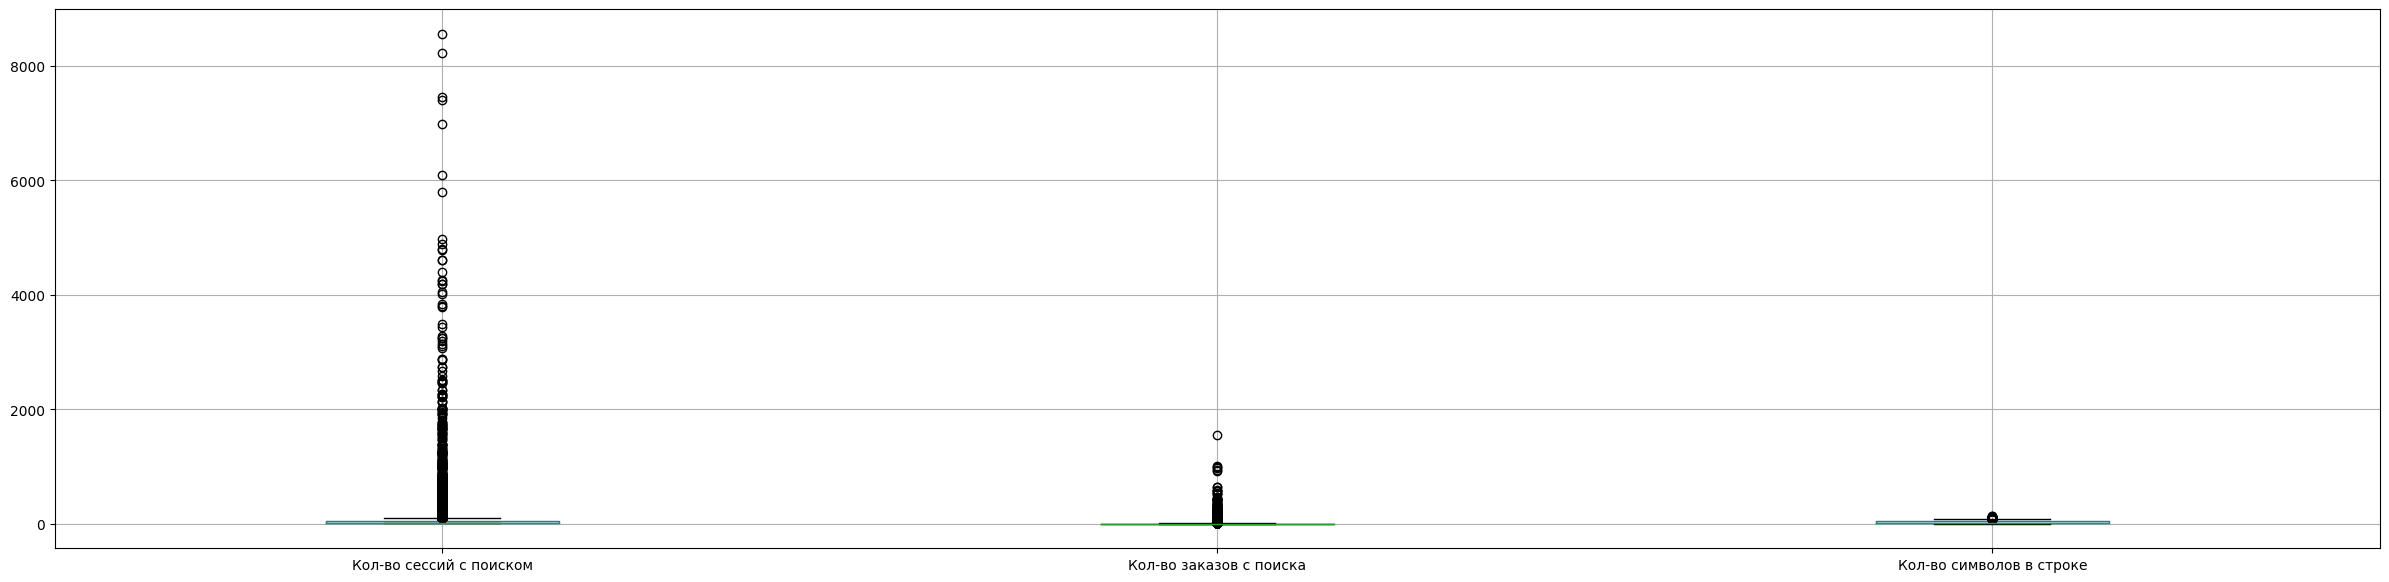

In [266]:
X.boxplot(figsize=(30,7))

<Axes: >

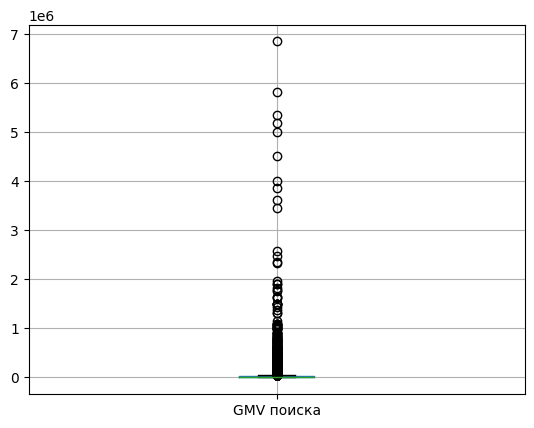

In [267]:
Y.boxplot()

**2.Обучение модели линейной регрессии**

In [268]:
#Делим данные на тестовую и обучающую выборки 20/70% соответственно

X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size = 0.2, random_state = 42)

In [269]:
#Обучение модели
model_lr = LinearRegression()
model_lr.fit(X_train, y_train)

LinearRegression()

In [270]:
# Предсказания
y_pred = model_lr.predict(X_test)

In [271]:
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt

# Оценка качества модели
mse = mean_squared_error(y_test, y_pred)
rmse = sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f'MSE: {mse}, RMSE: {rmse}, R2: {r2}')

MSE: 14104978532.912794, RMSE: 118764.38242551002, R2: 0.7245156696356165


Вывод:

Я выгрузил конверсию по запросам за апрель. (Куда вошли 20к запросов)

- Провёл первичный анализ данных, убрал строки с пропущенными значениями (выборка сократилась до 10к)

- Далее проверил выборку на выбросы. Выбрал основные признаки для обучения модели. Попробовал разные варианты, с удалением выбросов (https://colab.research.google.com/drive/1AZDsHv87tLowtu7VxxWjTiEvL6tGkR6p#scrollTo=iz39w94N3qAN) и без удаления (текущий колаб). По результатам анализа, выяснилось что выбросы полезны в рамках текущей задачи, на что указывала метрика R2 score. обученной модели линейной регрессии, т.к. после удаления выбросов она составила 0.0143, в то время как без обработки составляет 0.72 - это указывает на то, что модель хорошо обучилась.

- После я попробовал обучить модель случайного леса, но получил 0 по метрике точности. Поэтому для определения влияния длинны запроса на GMV поиска, будем использовать модель линейной регрессии

**3. Вычисление зависимости коэффициентов 'GVM поиска' от 'длины запроса' + влияние 'Кол-во сессий с поиском', 'Кол-во заказов с поиска'**

In [272]:
# Получим предсказания для сортированного X_test относительно 'Кол-во символов в строке'
sorted_index = X_test['Кол-во символов в строке'].argsort()
X_test_sorted = X_test.iloc[sorted_index]
y_pred_sorted = model_lr.predict(X_test_sorted)

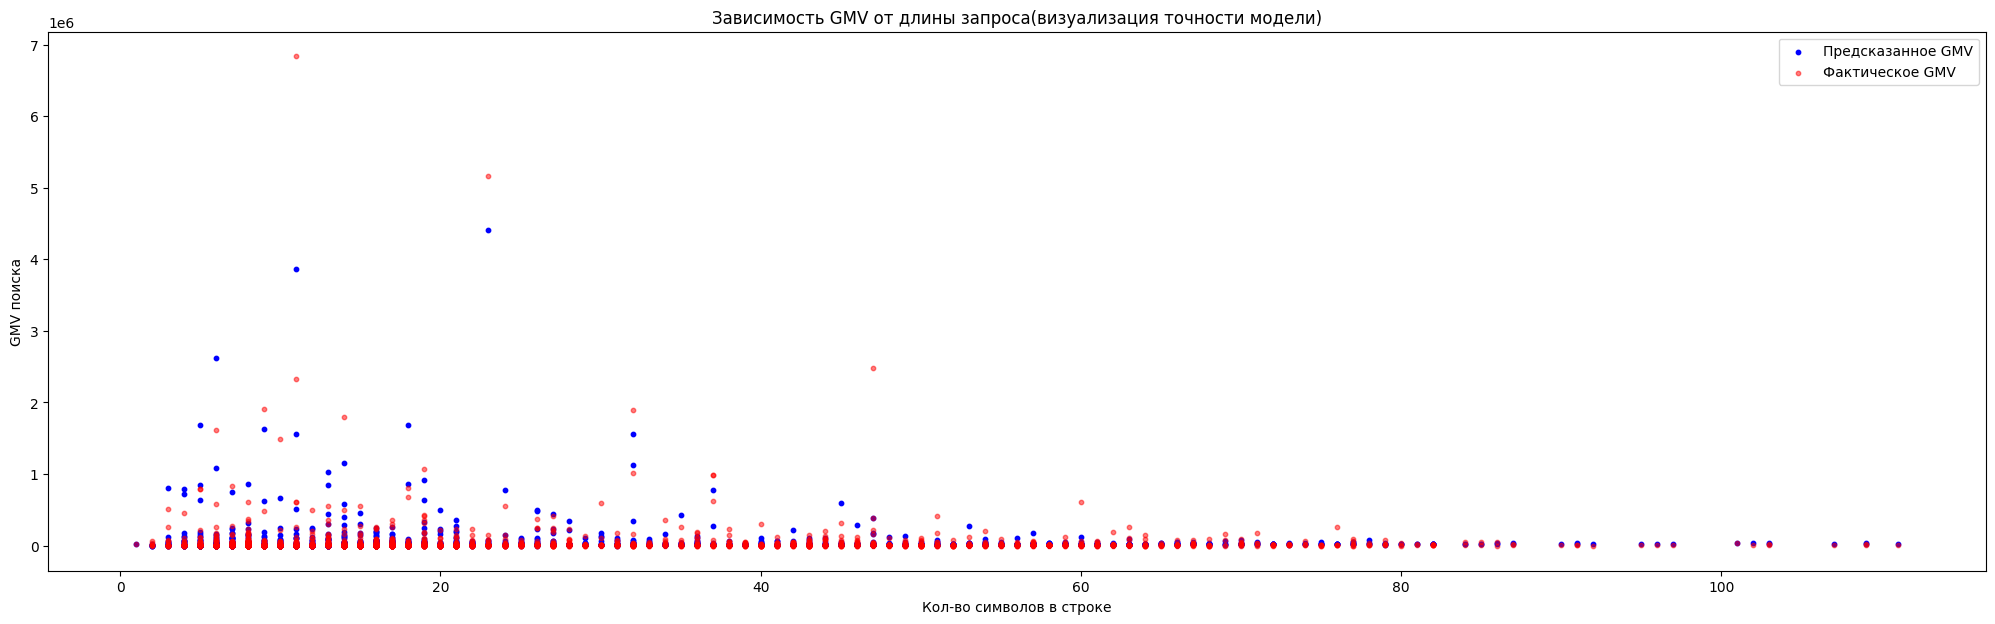

In [273]:
# Визуализация
plt.figure(figsize=(25,7))
plt.scatter(X_test_sorted['Кол-во символов в строке'], y_pred_sorted, color='blue', s=10, label='Предсказанное GMV')
plt.scatter(X_test['Кол-во символов в строке'], y_test, color='red', s=10, label='Фактическое GMV', alpha=0.5)
plt.xlabel('Кол-во символов в строке')
plt.ylabel('GMV поиска')
plt.title('Зависимость GMV от длины запроса(визуализация точности модели)')
plt.legend()
plt.show()

**Выведем в отдельные переменные, признаки для группировки "Кол-ва символов в строке" и построим модель на основе этих данных**

In [274]:
coefficients = pd.DataFrame(model_lr.coef_.T, index=X.columns, columns=['Coefficient'])
print(coefficients)

                          Coefficient
Кол-во сессий с поиском    556.685399
Кол-во заказов с поиска  -1164.074889
Кол-во символов в строке   304.955545


- **Коэффициент для "Кол-во сессий с поиском" равен 556.685399**. Это означает, что увеличение количества сессий с поиском на одну сессию ассоциировано с увеличением целевой переменной (GMV поиска) на примерно 556 единицы, при условии что все остальные признаки остаются неизменными. Положительный коэффициент указывает на прямую зависимость: **чем больше сессий с поиском, тем выше целевая переменная.**

- **Коэффициент для "Кол-во заказов с поиска" равен -1164.074889**. Отрицательный коэффициент говорит о том, что увеличение количества заказов с поиска на один заказ связано с уменьшением целевой переменной на примерно 1164 единицы. Это может показаться контринтуитивным, так как обычно ожидается, что увеличение количества заказов приведет к увеличению GMV. Однако этот коэффициент может отражать сложные взаимодействия между признаками или наличие других факторов, влияющих на данные.

- **Коэффициент для "Кол-во символов в строке" равен 304.955545**. Это означает, что увеличение длины строки запроса на один символ ассоциировано с увеличением целевой переменной на примерно 304 единиц. **Положительная зависимость может указывать на то, что более длинные запросы способствуют повышению прибыли от поиска.**

- **Положительный коэффициент** для `'Кол-во сессий с поиском'` и `'Кол-во символов в строке'` говорит о том, что увеличение этих признаков положительно влияет на `GMV поиска`. Это может быть интуитивно понятно, так как большее количество сессий с поиском и более длинные запросы могут указывать на повышенный интерес пользователей и потенциально привести к большему объему продаж.

- **Отрицательный коэффициент** для `'Кол-во заказов с поиска'` может показаться неожиданным, но это может быть связано с тем, что при увеличении количества заказов увеличиваются и отмены заказов, или же это может указывать на то, что большое количество малоценных поисковых запросов приводит к заказам, которые в меньшей степени способствуют общему GMV.

**Визуальный анализ:**

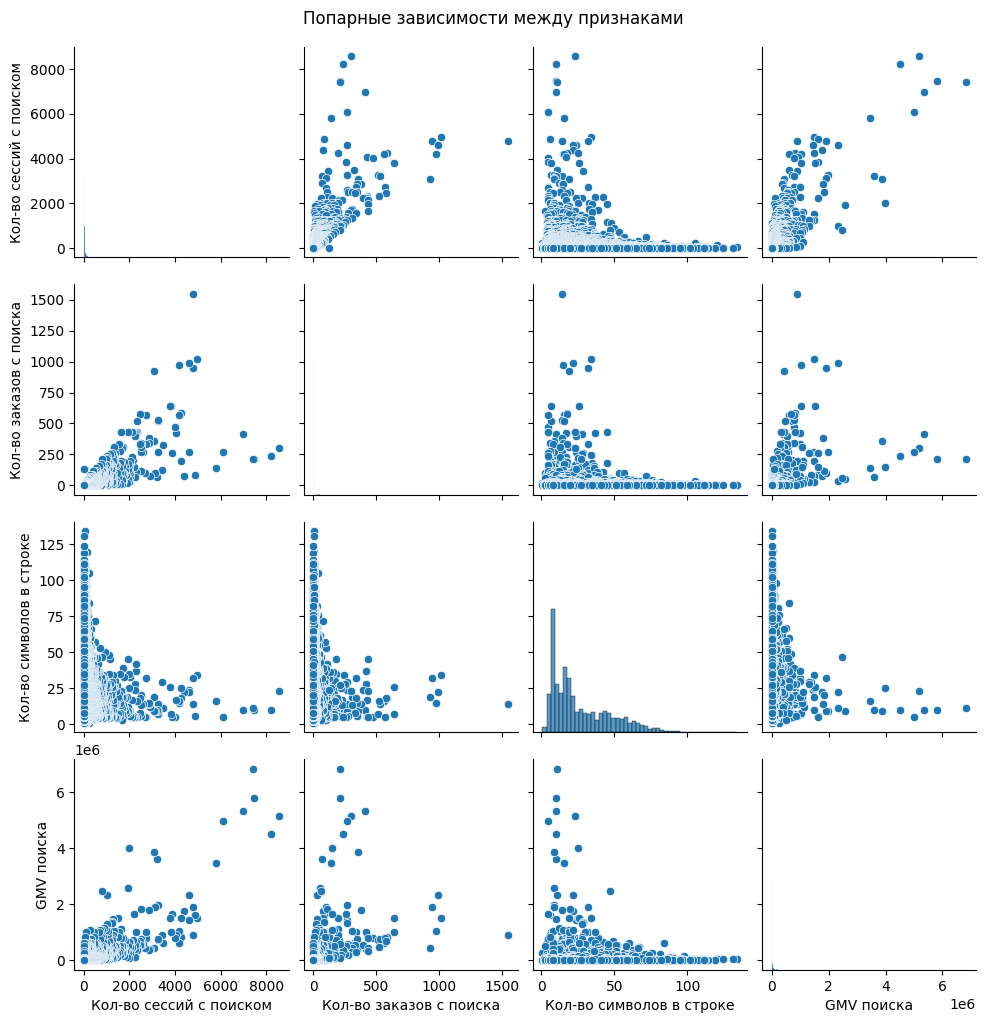

In [275]:

selected_columns = ['Кол-во сессий с поиском', 'Кол-во заказов с поиска', 'Кол-во символов в строке', 'GMV поиска']
subset_data = data[selected_columns]

# Визуализация
sns.pairplot(subset_data)
plt.suptitle('Попарные зависимости между признаками', y=1.02)
plt.show()

**На графиках ниже, визуально, можно определить запросов c зависимостью GMV поиска от Кол-ва символов в строке**

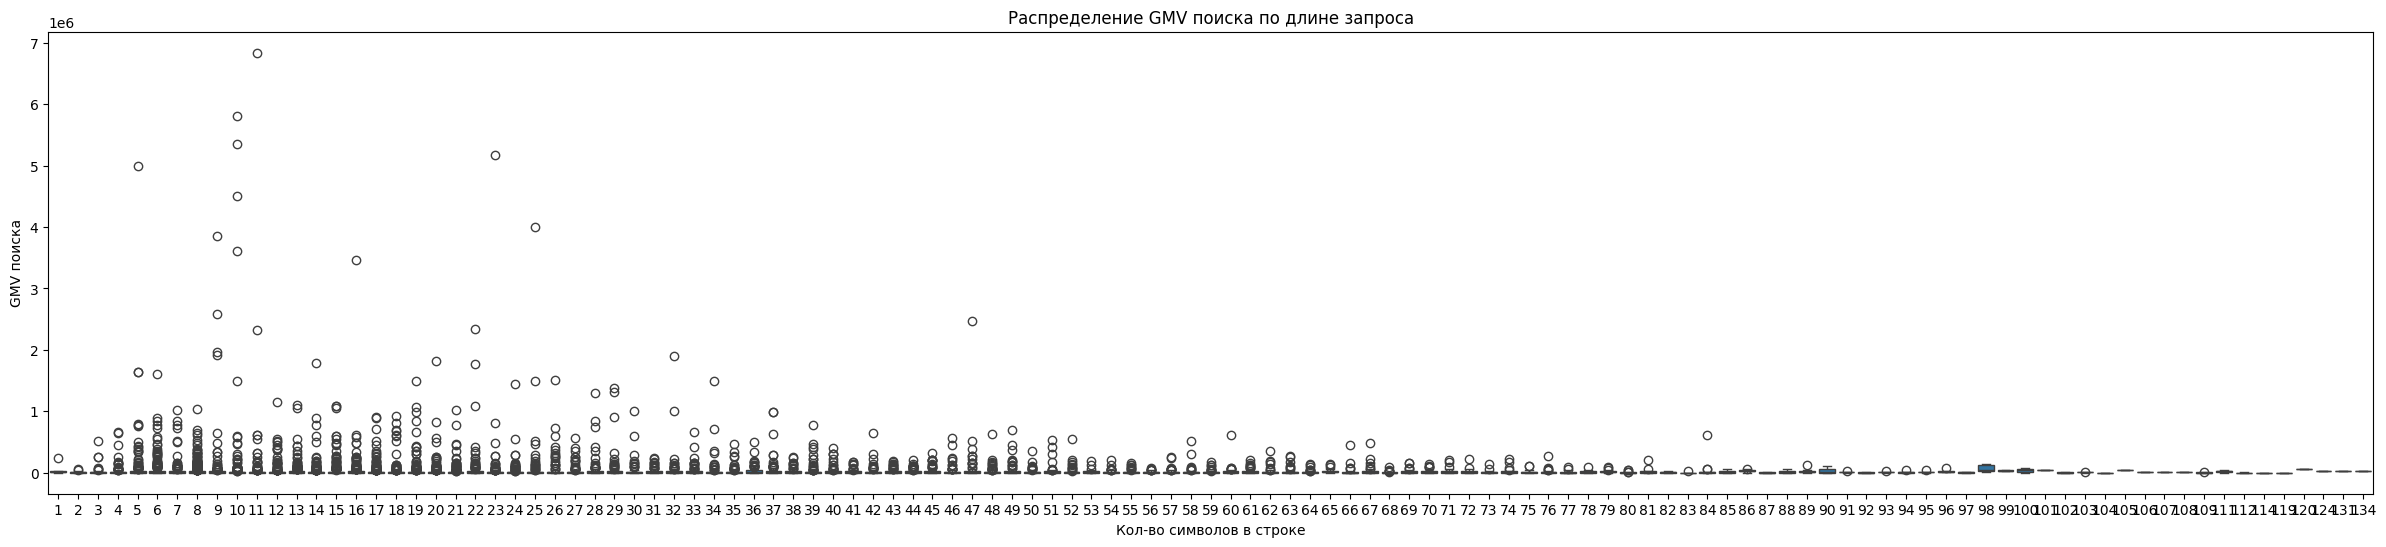

In [276]:
plt.figure(figsize=(30, 6))
sns.boxplot(x='Кол-во символов в строке', y='GMV поиска', data=data)
plt.title('Распределение GMV поиска по длине запроса')
plt.show()

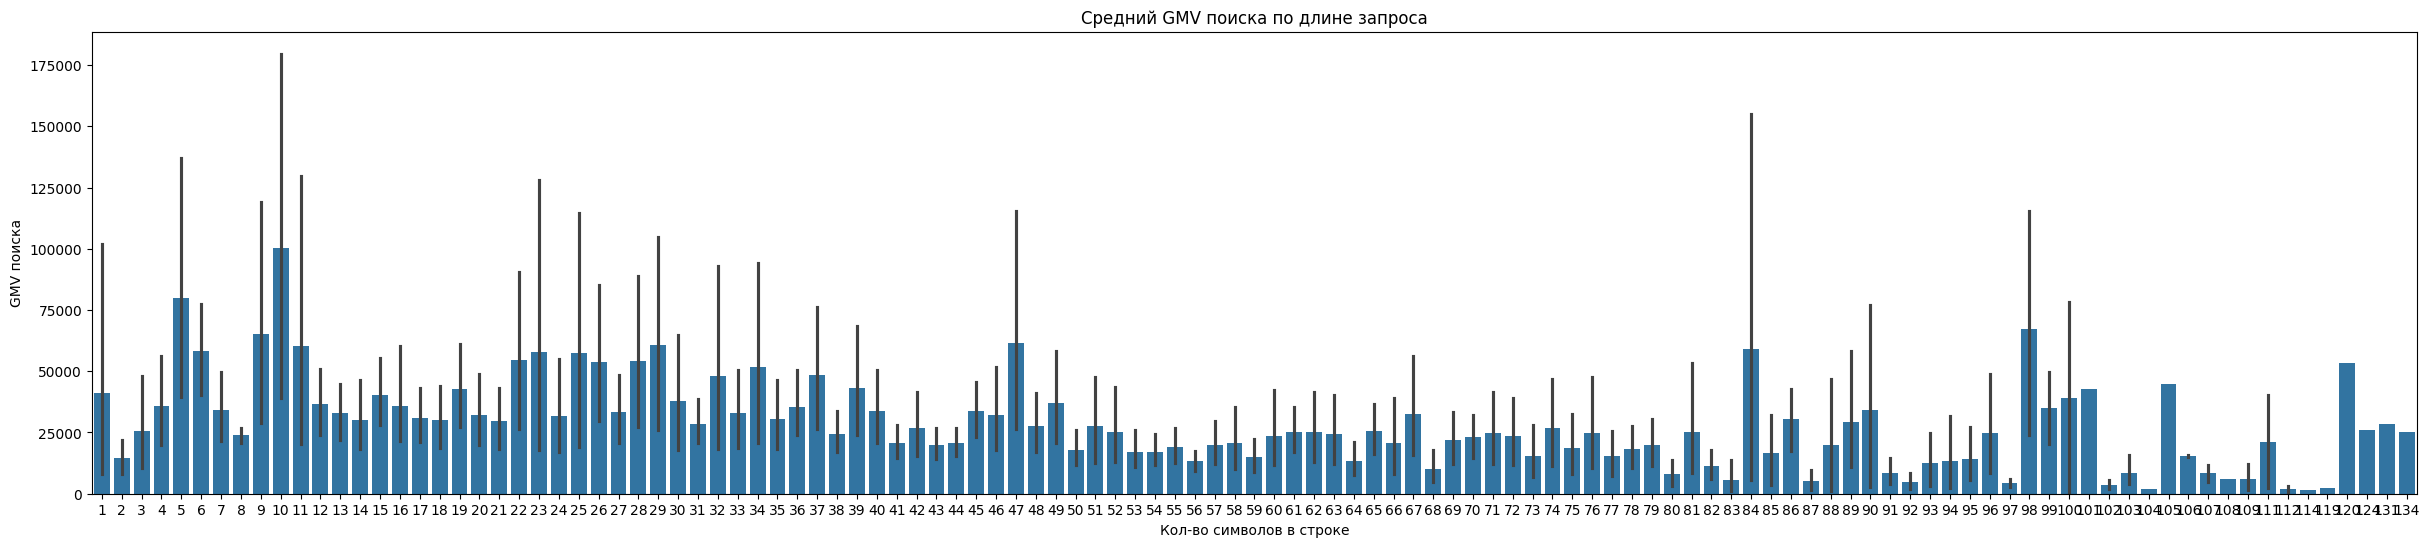

In [277]:
plt.figure(figsize=(30, 6))
sns.barplot(x='Кол-во символов в строке', y='GMV поиска', data=data, estimator=np.mean)
plt.title('Средний GMV поиска по длине запроса')
plt.show()

**Теперь разделим их на группы**

In [278]:
#Обратим внимание на минимальные и максимальные значения "кол-ва символов в строке"
x_group.describe()

,Кол-во сессий с поиском,Кол-во заказов с поиска
count,11199.000000,11199.000000
mean,84.646129,8.646576
std,324.318679,38.664829
min,10.000000,1.000000
25%,14.000000,1.000000
50%,23.000000,3.000000
75%,49.000000,5.000000
max,8561.000000,1547.000000


In [279]:
x_group = x[selected_features_x].copy()

y_group = y[selected_features_y]

In [280]:
# Шаг 1: Создание категориальных признаков по длине символов
x_group['Кол-во символов в строке'] = pd.cut(x_group['Кол-во символов в строке'],
                                 bins=[0, 20, 50, 80, 140],
                                 labels=['0-20', '20-50', '50-80', '80-140'])

In [281]:
x_group.head(5)

,Кол-во сессий с поиском,Кол-во заказов с поиска,Кол-во символов в строке
0,8561.0,299.0,20-50
1,8229.0,237.0,0-20
2,7460.0,213.0,0-20
3,7406.0,213.0,0-20
4,6989.0,415.0,0-20


In [282]:
#Теперь переведём каждую группу в булевое значение с помощью get_dummies
x_group_encoded = pd.get_dummies(x_group, columns=['Кол-во символов в строке'])

In [283]:
x_group_encoded.head()

,Кол-во сессий с поиском,Кол-во заказов с поиска,Кол-во символов в строке_0-20,Кол-во символов в строке_20-50,Кол-во символов в строке_50-80,Кол-во символов в строке_80-140
0,8561.0,299.0,False,True,False,False
1,8229.0,237.0,True,False,False,False
2,7460.0,213.0,True,False,False,False
3,7406.0,213.0,True,False,False,False
4,6989.0,415.0,True,False,False,False


In [284]:
#Обучим модель на основе этих данных
model_group_encoded = LinearRegression()
model_group_encoded.fit(x_group_encoded, y_group)

LinearRegression()

In [285]:
conditions = [
    x_group_encoded['Кол-во символов в строке_0-20'] == 1,
    x_group_encoded['Кол-во символов в строке_20-50'] == 1,
    x_group_encoded['Кол-во символов в строке_50-80'] == 1,
    x_group_encoded['Кол-во символов в строке_80-140'] == 1,
]

values = ['0-20', '20-50', '50-80', '80-140']

x_group_encoded['Категория длины символов'] = np.select(conditions, values, default='unknown')

In [287]:
#Впишем y в x, для вывода графиков
x_group_encoded['GMV поиска'] = y_group['GMV поиска']

In [289]:
x_group_encoded.head()

,Кол-во сессий с поиском,Кол-во заказов с поиска,Кол-во символов в строке_0-20,Кол-во символов в строке_20-50,Кол-во символов в строке_50-80,Кол-во символов в строке_80-140,Категория длины символов,GMV поиска
0,8561.0,299.0,False,True,False,False,20-50,5169480.0
1,8229.0,237.0,True,False,False,False,0-20,4503354.0
2,7460.0,213.0,True,False,False,False,0-20,5809503.0
3,7406.0,213.0,True,False,False,False,0-20,6838667.0
4,6989.0,415.0,True,False,False,False,0-20,5347270.0


In [290]:
#Определим порядок категориальных значений
order = ['0-20', '20-50', '50-80', '80-140']

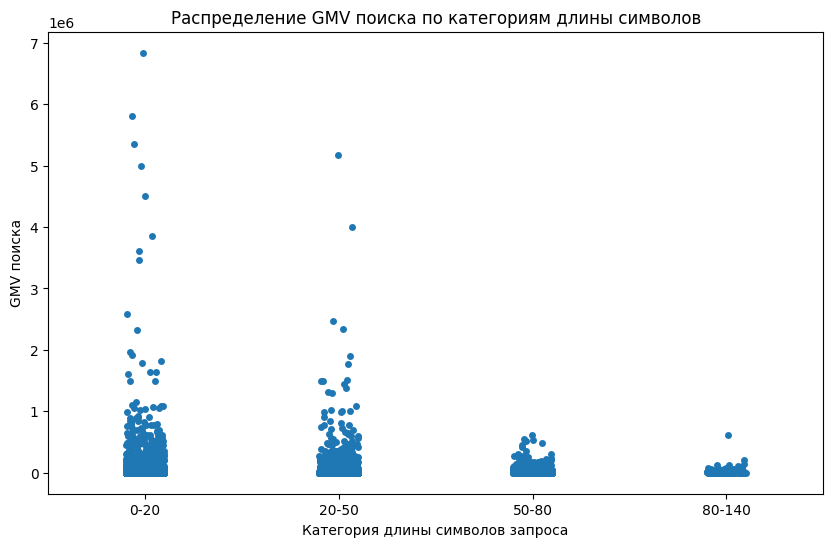

In [291]:
plt.figure(figsize=(10, 6))
sns.stripplot(x='Категория длины символов', y='GMV поиска', data=x_group_encoded, order=order)
plt.title('Распределение GMV поиска по категориям длины символов')
plt.xlabel('Категория длины символов запроса')
plt.ylabel('GMV поиска')
plt.show()

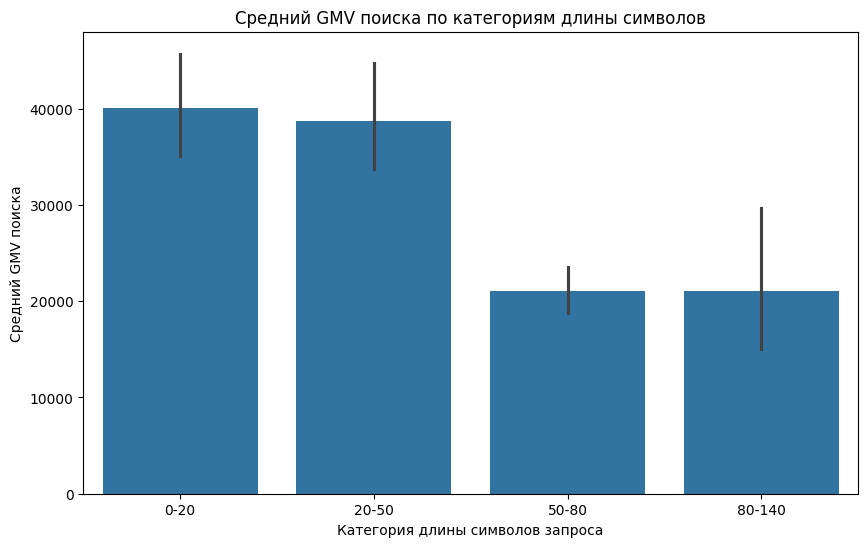

In [292]:
plt.figure(figsize=(10, 6))
sns.barplot(x='Категория длины символов', y='GMV поиска', data=x_group_encoded, estimator=np.mean, order=order)
plt.title('Средний GMV поиска по категориям длины символов')
plt.xlabel('Категория длины символов запроса')
plt.ylabel('Средний GMV поиска')
plt.show()